In [3]:
import matplotlib.pyplot as plt
import matplotlib
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
matplotlib.style.use('ggplot')
'''SEED Everything'''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True # keep True if all the input have same size.
SEED=42
seed_everything(SEED=SEED)

In [4]:
BATCH_SIZE = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
image_paths = list(paths.list_images('Caltech101/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

<ipython-input-6-5e5f352fe760>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)


In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")

Total number of classes: 101


In [13]:
dataset_config = {'size': 64, 'channels': 3, 'classes': len(lb.classes_)}
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((dataset_config['size'], dataset_config['size'])),
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((dataset_config['size'],dataset_config['size'])),
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
]) 

In [23]:
# divide the data into train, validation, and test set
(X, x_val , Y, y_val) = train_test_split(data, labels, 
                                                    test_size=0.1,  
                                                    stratify=labels,
                                                    random_state=42)
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.15, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6637,)
x_test examples: (1172,)
x_val examples: (868,)


In [24]:
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

In [25]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        # change the classification layer
        self.l0 = nn.Linear(512, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0
model = ResNet34(pretrained=True).to(device)

In [34]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss function
criterion = nn.CrossEntropyLoss()

In [35]:
def train(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [36]:
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [37]:
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, target = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == torch.max(target, 1)[1]).sum().item()
    return correct, total

Training on 6637 examples, validating on 868 examples...
Epoch 1 of 10
Training


415it [00:13, 31.40it/s]                         


Train Loss: 0.1519, Train Acc: 48.50
Validating


55it [00:00, 88.62it/s]                        


Val Loss: 0.0686, Val Acc: 73.62
Epoch 2 of 10
Training


415it [00:13, 30.68it/s]                         


Train Loss: 0.0620, Train Acc: 76.80
Validating


55it [00:00, 89.71it/s]                        


Val Loss: 0.0425, Val Acc: 82.14
Epoch 3 of 10
Training


415it [00:13, 30.53it/s]                         


Train Loss: 0.0325, Train Acc: 87.25
Validating


55it [00:00, 89.17it/s]                        


Val Loss: 0.0350, Val Acc: 85.14
Epoch 4 of 10
Training


415it [00:13, 30.07it/s]                         


Train Loss: 0.0176, Train Acc: 93.31
Validating


55it [00:00, 85.33it/s]                        


Val Loss: 0.0366, Val Acc: 85.83
Epoch 5 of 10
Training


415it [00:13, 30.24it/s]                         


Train Loss: 0.0113, Train Acc: 95.60
Validating


55it [00:00, 88.47it/s]                        


Val Loss: 0.0348, Val Acc: 86.52
Epoch 6 of 10
Training


415it [00:13, 30.30it/s]                         


Train Loss: 0.0089, Train Acc: 96.46
Validating


55it [00:00, 89.75it/s]                        


Val Loss: 0.0354, Val Acc: 86.06
Epoch 7 of 10
Training


415it [00:13, 30.54it/s]                         


Train Loss: 0.0069, Train Acc: 97.56
Validating


55it [00:00, 90.04it/s]                        


Val Loss: 0.0393, Val Acc: 85.60
Epoch 8 of 10
Training


415it [00:13, 30.49it/s]                         


Train Loss: 0.0072, Train Acc: 97.08
Validating


55it [00:00, 87.45it/s]                        


Val Loss: 0.0409, Val Acc: 85.14
Epoch 9 of 10
Training


415it [00:13, 30.45it/s]                         


Train Loss: 0.0059, Train Acc: 97.74
Validating


55it [00:00, 86.11it/s]                        


Val Loss: 0.0408, Val Acc: 85.83
Epoch 10 of 10
Training


415it [00:13, 30.39it/s]                         


Train Loss: 0.0059, Train Acc: 97.85
Validating


55it [00:00, 88.26it/s]                        


Val Loss: 0.0414, Val Acc: 85.14
2.372374431292216 minutes


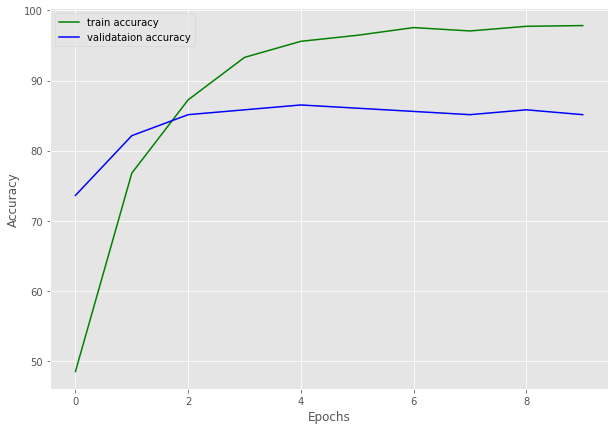

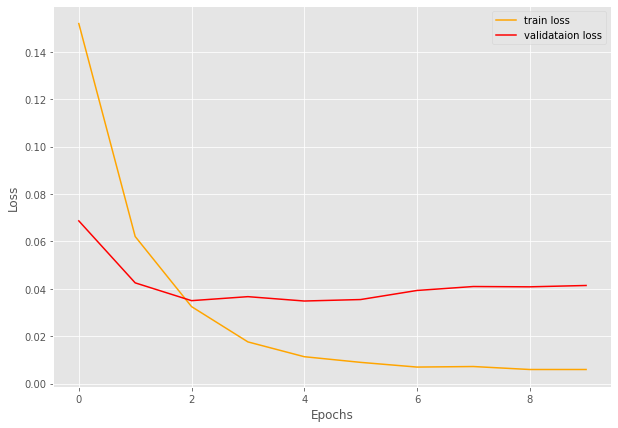

In [38]:
epochs = 10
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

torch.save(model.state_dict(), f"classification_outputs/models/resnet34_epochs{epochs}.pth")

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('classification_outputs/plots/accuracy.png')

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('classification_outputs/plots/loss.png')

In [32]:
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

Accuracy of the network on test images: 85.495 %
train.py finished running
